In [8]:
'''
https://github.com/CamDavidsonPilon/tdigest
https://medium.com/@mani./t-digest-an-interesting-datastructure-to-estimate-quantiles-accurately-b99a50eaf4f7
'''

import numpy as np
import seaborn as sns
from numpy.random import random
# from tdigest import TDigest
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
from scipy.stats import power_divergence
import pandas as pd
%matplotlib inline

# TDigest Custom

In [18]:
class TDigestCustom():
    
    def __init__(self, k, method):
        self.K = k
        self.klasts = []
        
        self.kminus_one = None
        self.kth = None
        
        self.kminus_one_hist = None
        self.kth_hist = None
        
        self.method = method
        self.statistics = None
        self.p_value = None
        
        self.nbatch = None
        
    def add(self, x):
        self.klasts.append(x)
        if len(self.klasts) > self.K:
            self.klasts.pop(0)
            
        if self.nbatch is None:
            self.nbatch = len(x)
            
        self._get_kminus_one()
        self._get_kth()
        
    def get_stats(self):
        self._comp_statistics()
        return self.statistics, self.p_value
            
    def _get_kminus_one(self):
        if len(self.klasts) >= self.K:
            self.kminus_one = np.array(self.klasts[:-1]).flatten()
            self.kminus_one_hist = self._get_hist(self.kminus_one)
            
    def _get_kth(self):
        if len(self.klasts) >= self.K:
            self.kth = np.array(self.klasts[-1])
            self.kth_hist = self._get_hist(self.kth)
            
    def _get_hist(self, x):
        flatten_array = np.array(self.klasts).flatten()
        xmin, xmax = np.min(flatten_array), np.max(flatten_array)
        hist, _ = np.histogram(x, range=(xmin, xmax), density=True)
        # Normalized to do number of observations the same; plus 1 - to eliminate zeros in bins
        return np.array(hist*self.nbatch, dtype='int')+1
            
    def _comp_statistics(self):
        if self.method == 'ks':
            self.statistics, self.p_value = stats.ks_2samp(self.kminus_one, self.kth)
        elif self.method == 'gtest':
            self.statistics, self.p_value = power_divergence(self.kth_hist, self.kminus_one_hist, lambda_='log-likelihood')
        else:
            raise Exception('Unknown method. Please provide KS or GTEST.')
            

def simulation(nobs_step, nobs_total, method, k):
    nobs_current = 0
    step = 0
    tdigest = TDigestCustom(k=k, method=method)
    statistics = []
    p_values = []
    anomaly_points = []
    while nobs_current <= nobs_total:
        # make a step
        step += 1
        trigger = np.random.random()
        if trigger > 0.9:
            anomaly_points.append(step)
        step_values = np.random.normal((lambda x: 1 if x < 0.9 else 2)(trigger), 1, nobs_step)
        tdigest.add(step_values)
        nobs_current += nobs_step

        if step >= k:
            stat, p_value = tdigest.get_stats()
            statistics.append(stat)
            p_values.append(p_value)
        else:
            pass
    print(step)
    for x in anomaly_points:
        plt.axvline(x)
    plt.plot(range(k, step+1), statistics, 'ro')
    print('TOTAL NUMBER of ANOMALIES: ', len(anomaly_points))
    plt.show()    
    return tdigest

76
TOTAL NUMBER of ANOMALIES:  8


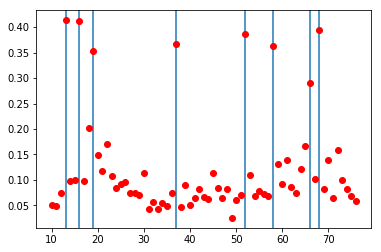

In [19]:
np.random.seed(1)
digest = simulation(nobs_step=200, nobs_total=15000, method='ks', k=10)

# Simulation

In [50]:
class Simulation(object):
    def __init__(self, tdigest,
                 step_size=200,
                 size=15000,
                 anomaly_threshold=0.9,
                 distribution='normal',
                 linspace_size=100,
                 d_params={'mu': 1, 'mu_anom': 2, 'stddev': 1}):
        super().__init__()
        self.__tdigest = tdigest
        self.__window = tdigest.K
        self.size = size
        self.s_size = step_size
        self.a_thres = anomaly_threshold
        self.__values = np.empty((0, step_size), float)
        self.__labels = np.array([])
        self.__linspace_size = linspace_size
        self.__cdfs = []
        self.statistics = np.array([])
        self.p_values = np.array([])
        self.__tdigest_custom = False
        self.__tdigest_custom_change_attempt = 0
        if distribution == 'normal':
            mu = d_params['mu']
            mu_a = d_params['mu_anom']
            stdev = d_params['stddev']
            self.get_values = lambda is_anomaly: np.random.normal((lambda x: mu if not x else mu_a)
                                                                  (is_anomaly), stdev, self.s_size)
            
        
    def __change_tdigest_status(self, custom):
        if self.__tdigest_custom_change_attempt == 0:
            self.__tdigest_custom_change_attempt += 1
            self.__tdigest_custom = custom
        else:
            if custom != self.__tdigest_custom:
                raise Exception("error in changing tdigest_status")      
    
    def __update(self, step_values):
        try:
            self.__tdigest.batch_update(step_values)
            self.__change_tdigest_status(False)
        except:
            self.__tdigest.add(step_values)
            self.__change_tdigest_status(True)
    
    def __compute(self, step_values, i):
        try:
            if i > self.__window:
                stat, p_value = self.__tdigest.get_stats()
                self.statistics = np.append(self.statistics, stat)
                self.p_values = np.append(self.p_values, p_value)
            self.__change_tdigest_status(True)
        except:
            if i > self.__window:
                prev_cdf = []
                curr_cdf = []
                ls = np.linspace(min(step_values),
                                 max(step_values),
                                 self.__linspace_size)
                for x in ls:
                    prev_cdf.append(self.__tdigest.cdf(x))
                prev_cdf = np.array(prev_cdf)

                ecdf = ECDF(step_values)
                curr_cdf = ecdf(ls)
                self.__cdfs.append((prev_cdf, curr_cdf))
            self.__change_tdigest_status(False)
        self.__update(step_values)
        
    def plot_statistics(self):
        x = range(self.__window, len(self.statistics) + self.__window)
        y = self.statistics
        for x, y, l in zip(x, y, self.__labels[self.__window:]):
            if l == 0:
                plt.scatter(x, y, c='blue')
            else:
                plt.scatter(x, y, c='red')
        plt.show()

    def get_values(self):
        return self.__values

    def get_labels(self):
        return self.__labels
    
    def get_cdfs(self):
        return self.__cdfs
        
    def run(self):
        step = 0
        i = 0
        while step <= self.size:
            is_anomaly = np.random.random() > self.a_thres
            step_values = self.get_values(is_anomaly)
            self.__labels = np.concatenate([self.__labels, [int(is_anomaly)]])
            self.__values = np.concatenate([self.__values,
                                            step_values.reshape((1, -1))])
            self.__compute(step_values, i)
            step += self.s_size
            i += 1

# TDigest custom test

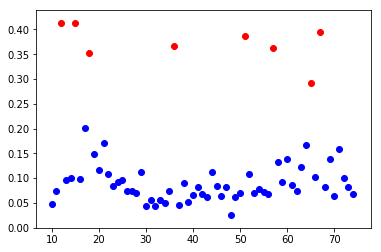

In [51]:
def tdigest_test_custom():
    np.random.seed(1)
    tdigest = TDigestCustom(k=10, method='ks')
    sim = Simulation(tdigest,
                     step_size=200,
                     size=15000,
                     anomaly_threshold=0.9,
                     distribution='normal',
                     d_params={'mu': 1, 'mu_anom': 2, 'stddev': 1})
    sim.run()
#     labels = sim.get_labels()
#     print(sim.p_values)
    sim.plot_statistics()
#     print(sim.statistics)
tdigest_test_custom()

# TDigest test

In [118]:
tdigest = TDigest(K=5)
sim = Simulation(tdigest,
                 step_size=10,
                 size=100,
                 anomaly_threshold=0.9)
sim.run()
print(sim.get_values())
sim.get_cdfs()

[[-1.43470004  3.33989969 -0.98848126 -2.75031435  3.21762184  8.56081958
   6.1248653   6.36488009 11.83759353 -2.00558591]
 [ 3.66846479 -3.38000806  5.00093466 -1.12184827  0.65553542 -0.42202175
  -5.84037127  2.95378193 -3.37712635  1.21015178]
 [-0.13044423 -4.98696987 11.48746224 -4.37550642 -0.5038416  11.32762084
   0.64067422  5.17832784 -2.17870197 -1.68466886]
 [ 2.81001809 11.16550809 -0.08743436 12.39854454 -1.0045986   2.96791104
  -3.62559559  3.6329843  -4.98012173 -3.79256267]
 [ 0.70012489  0.55375355 -7.22348787 -0.36349793  0.79992216  4.05900368
  -3.71768703 -2.96217921  1.43455644  6.73343633]
 [-0.08135478  0.64166196  8.17544335  1.06161444  0.4021015   7.13454396
  -1.2177164  -7.88146784  1.889273    4.84528325]
 [ 2.21716002 -6.60423909 10.33414885 10.11458672 -1.41097281  5.47183409
   3.14061341 -3.54126591  7.68228569  1.22103565]
 [-3.89456731 -1.22503693 -0.95953862  1.05384395  1.49580423  4.96475494
  -3.71230925  0.48340075 -3.46271812 -0.60099356]


[(array([4.85545950e-04, 2.83084384e-03, 5.17614172e-03, 7.52143961e-03,
         9.86673750e-03, 1.22120354e-02, 1.45573333e-02, 1.69026312e-02,
         1.92479290e-02, 2.00000000e-02, 2.01761035e-02, 2.39771524e-02,
         2.77782013e-02, 3.15792503e-02, 3.53802992e-02, 3.91813481e-02,
         4.00000000e-02, 4.00000000e-02, 7.05984728e-02, 7.59635709e-02,
         8.10063028e-02, 8.65708542e-02, 9.21354057e-02, 9.76999571e-02,
         1.00000000e-01, 1.00883655e-01, 1.46831625e-01, 1.60000000e-01,
         1.91783703e-01, 1.99601134e-01, 2.04944139e-01, 2.26388049e-01,
         2.32062909e-01, 2.37737769e-01, 2.40000000e-01, 2.46986981e-01,
         2.67693789e-01, 2.77801760e-01, 2.87316454e-01, 3.02244382e-01,
         3.12612936e-01, 3.20000000e-01, 3.38938765e-01, 3.73352073e-01,
         3.80000000e-01, 3.80000000e-01, 4.10458251e-01, 4.39011496e-01,
         4.69723500e-01, 4.74782579e-01, 4.79841659e-01, 4.80000000e-01,
         4.89703583e-01, 5.52912192e-01, 5.73750348

# PDF/CDF transform

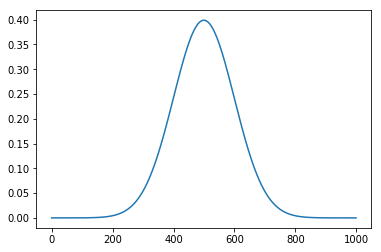

In [115]:
from numpy import diff

rvs = stats.norm
x = np.linspace(-5, 5, 1000)

rv = stats.norm
pdf = rv.pdf(x)
plt.plot(pdf)
plt.show()

# cdf = stats.norm.cdf(x, loc=0, scale=1)
# plt.plot(x, cdf)
# plt.show()

# pdf_1 = diff(cdf)/diff(x)
# sns.distplot(pdf_1)
# plt.show()

# pdf = np.random.normal(0, 2, 100)
# print(pdf)
# sns.distplot(pdf)
# plt.show()

# ecdf = ECDF(pdf)
# ls = np.linspace(-5, 5, 100 + 1)
# cdf = ecdf(ls)
# plt.plot(ls, cdf)
# plt.show()

# dx = ls[1]-ls[0]
# pdf_1 = diff(cdf)
# print(pdf_1)
# sns.distplot(pdf_1)
# plt.show()
# # pdf_1 =/ 


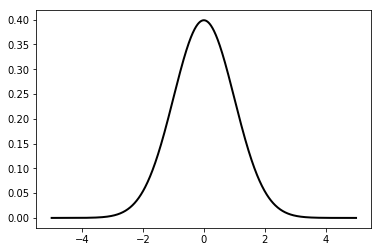

In [112]:
rv = stats.norm()
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')